In [1]:
import random
import numpy as np
import tensorflow as tf
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
from sklearn.utils import shuffle


In [2]:
# Load pickled data
import pickle

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


In [3]:
### Dataset Summary

n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:3]
n_classes = np.unique(y_train).shape[0]
n_channels = X_train.shape[3]
print (X_train.shape)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Number of channels =", n_channels)

(34799, 32, 32, 3)
Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43
Number of channels = 3


4


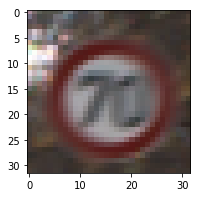

In [4]:
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(3,3))
plt.imshow(image, cmap="gray")
print(y_train[index])

In [5]:
# Preprocess the cells

def preprocess(x):
    return (x-128.0)/128.0

# Normalize all of the data
X_train_n = preprocess(X_train)
X_valid_n = preprocess(X_valid)
X_test_n = preprocess(X_test)

Using TensorFlow backend.


12


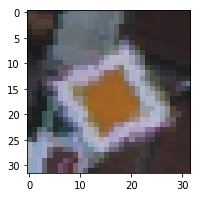

In [6]:
#X_aug, y_aug = augment_images(X_train_n, y_train)

from keras.preprocessing.image import random_rotation, random_zoom

def augment_image(image):
    image = random_zoom(image, (0.9, 1.1), row_axis=0, col_axis=1, channel_axis=2)
    image = random_rotation(image, 20 ,row_axis=0, col_axis=1, channel_axis=2)
    return image

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(3,3))
plt.imshow(augment_image(image), cmap="gray")
print(y_train[index])

# Shuffle
X_train_n, y_train = shuffle(X_train_n, y_train)

In [7]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], n_channels), name="input")
y = tf.placeholder(tf.int32, (None), name="output")
dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
training = tf.placeholder(tf.bool, name='training')

one_hot_y = tf.one_hot(y, n_classes)

from tensorflow.contrib.layers import flatten
   
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# Data Augmentation:
x_aug = tf.map_fn(lambda img: tf.image.random_brightness(img,0.1), x)
x_aug = tf.map_fn(lambda img: tf.image.random_contrast(img,0.9,1.1), x_aug)
x_aug = tf.map_fn(lambda img: tf.image.random_hue(img,0.1), x_aug)

x_input = tf.cond(training, lambda: x_aug, lambda: x)

# SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, n_channels, 6), mean = mu, stddev = sigma), name="conv1_W")
conv1_b = tf.Variable(tf.zeros(6), name="conv1_b")
conv1   = tf.nn.conv2d(x_input, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

# SOLUTION: Activation.
conv1 = tf.nn.relu(conv1)

# SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="conv2_W")
conv2_b = tf.Variable(tf.zeros(16), name="conv2_b")
conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

# SOLUTION: Activation.
conv2 = tf.nn.relu(conv2)

# SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# SOLUTION: Flatten. Input = 5x5x16. Output = 400.
fc0   = flatten(conv2)

# SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name="fc1_W")
fc1_b = tf.Variable(tf.zeros(120), name="fc1_b")
fc1   = tf.matmul(fc0, fc1_W) + fc1_b

# SOLUTION: Activation.
fc1    = tf.nn.relu(fc1)
fc1    = tf.nn.dropout(fc1, keep_prob=dropout_rate)

# SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="fc2_W")
fc2_b  = tf.Variable(tf.zeros(84), name="fc2_b")
fc2    = tf.matmul(fc1, fc2_W) + fc2_b

# SOLUTION: Activation.
fc2    = tf.nn.relu(fc2)
fc2    = tf.nn.dropout(fc2, keep_prob=dropout_rate)

# SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 43.
fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma), name="fc3_W")
fc3_b  = tf.Variable(tf.zeros(n_classes), name="fc3_b")
logits = tf.matmul(fc2, fc3_W) + fc3_b

In [11]:
EPOCHS = 50
BATCH_SIZE = 128

In [12]:
rate = 0.001

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: 1.0, training: False})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_n)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_n, y_train = shuffle(X_train_n, y_train)
        
        X_aug = np.empty_like(X_train_n)
        for idx, image in enumerate(X_train_n):
            X_aug[idx] = augment_image(X_train_n[idx])
            
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_aug[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, dropout_rate: 0.5, training: True})
            
        validation_accuracy = evaluate(X_valid_n, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.524

EPOCH 2 ...
Validation Accuracy = 0.713

EPOCH 3 ...
Validation Accuracy = 0.782

EPOCH 4 ...
Validation Accuracy = 0.851

EPOCH 5 ...
Validation Accuracy = 0.870

EPOCH 6 ...
Validation Accuracy = 0.878

EPOCH 7 ...
Validation Accuracy = 0.892

EPOCH 8 ...
Validation Accuracy = 0.898

EPOCH 9 ...
Validation Accuracy = 0.908

EPOCH 10 ...
Validation Accuracy = 0.921

EPOCH 11 ...
Validation Accuracy = 0.925

EPOCH 12 ...
Validation Accuracy = 0.930

EPOCH 13 ...
Validation Accuracy = 0.930



In [ ]:
import cv2
names = ['1.jpg','2.jpg','3.jpg','4.jpg', '5.jpg']

X_new = np.array([np.array(cv2.cvtColor(cv2.imread('new_images/' + fname), cv2.COLOR_RGB2BGR)) for fname in names])
X_new = preprocess(X_new)


In [ ]:
import tensorflow as tf
import csv
#output = tf.arg_max(logits, 1)
output = tf.nn.softmax(logits)

out = []
with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph('./signs.meta')
    new_saver.restore(sess,tf.train.latest_checkpoint('./'))
    #print(sess.run(tf.global_variables()))
    out = sess.run(output,feed_dict={x: X_new, dropout_rate: 1.0, training: False})

names = []
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        names.append(row[1])
names = names[1:]
        
for i in range(len(X_new)):
    plt.figure(figsize=(3,3))
    plt.imshow(np.uint8(128.0*X_new[i]+128.0))
    plt.show()
    
    k = np.stack([np.arange(n_classes),out[i]]).transpose()
    k = np.flip(k[k[:,1].argsort()],0)
    k = k[0:5,:]
    for j in range(5):
        idx = np.int32(k[j,0])
        print("Class[%d]: %s (%.6f)" % (idx,names[idx],k[j,1]))